In [ ]:
# Brazilian E-Commerce Analysis (Olist Dataset)

Author: Mariia Semenova
Tools: Python, Pandas, Matplotlib, PostgreSQL

---

# Project Objective

Perform exploratory data analysis (EDA), clean the data, identify high-value orders, and prepare structured datasets for PostgreSQL integration.

Dataset: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

In [6]:
# 1. Import Libraries

import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Display settings for better readability
pd.set_option("display.max_columns", None)
plt.style.use("ggplot")



In [14]:
# 2. Load Data

DATA_PATH = "olist_data"

# Load all CSV files into dictionary
tables = {
    file.replace(".csv", ""): pd.read_csv(os.path.join("/kaggle/olist_data", file))
    for file in os.listdir("/kaggle/olist_data")
    if file.endswith(".csv")
}

print(f"Loaded {len(tables)} tables.")

Loaded 9 tables.


In [15]:
# 3. Dataset overview

for table_name, df in tables.items():
    print(f"\nTable: {table_name}")
    print("Shape:", df.shape)
    print("Missing values:", df.isna().sum().sum())
    print("Duplicates:", df.duplicated().sum())



Table: product_category_name_translation
Shape: (71, 2)
Missing values: 0
Duplicates: 0

Table: olist_orders_dataset
Shape: (99441, 8)
Missing values: 4908
Duplicates: 0

Table: olist_order_reviews_dataset
Shape: (99224, 7)
Missing values: 145903
Duplicates: 0

Table: olist_products_dataset
Shape: (32951, 9)
Missing values: 2448
Duplicates: 0

Table: olist_order_payments_dataset
Shape: (103886, 5)
Missing values: 0
Duplicates: 0

Table: olist_order_items_dataset
Shape: (112650, 7)
Missing values: 0
Duplicates: 0

Table: olist_sellers_dataset
Shape: (3095, 4)
Missing values: 0
Duplicates: 0

Table: olist_customers_dataset
Shape: (99441, 5)
Missing values: 0
Duplicates: 0

Table: olist_geolocation_dataset
Shape: (1000163, 5)
Missing values: 0
Duplicates: 261831


In [16]:
# 4. Customer Data Analysis

customers = tables["olist_customers_dataset"]

# Basic info
print(customers.info())

# Missing values
print("Missing values:\n", customers.isna().sum())

# Duplicate rows
print("Duplicate rows:", customers.duplicated().sum())

# Unique customers
print("Unique customers:", customers["customer_unique_id"].nunique())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
Missing values:
 customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
Duplicate rows: 0
Unique customers: 96096


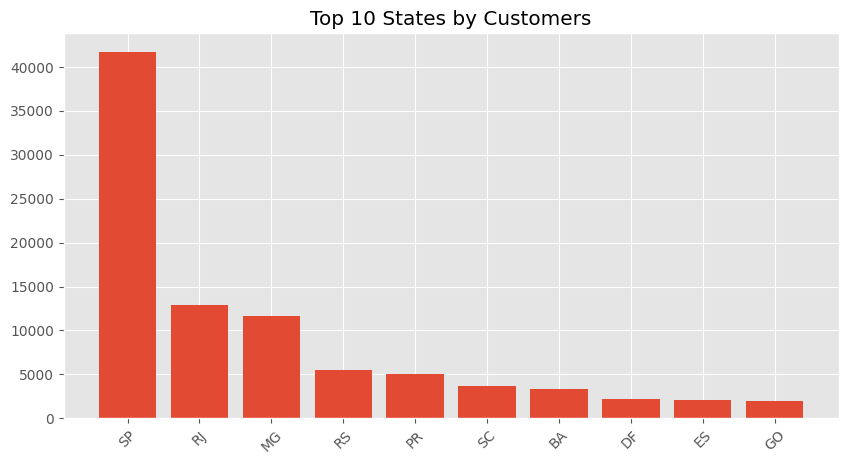

In [17]:
# Customer Analysis (Georaphical distribution by state)

customers = tables["olist_customers_dataset"]

top_states = customers["customer_state"].value_counts().head(10)

plt.figure(figsize=(10,5))
plt.bar(top_states.index, top_states.values)
plt.title("Top 10 States by Customers")
plt.xticks(rotation=45)
plt.show()


In [18]:
# 5. Produsts Data Cleaning

products = tables["olist_products_dataset"]

# Check missing values
missing_products = products.isna().sum().sort_values(ascending=False)
print(missing_products)


product_category_name         610
product_description_lenght    610
product_name_lenght           610
product_photos_qty            610
product_weight_g                2
product_height_cm               2
product_length_cm               2
product_width_cm                2
product_id                      0
dtype: int64


In [19]:
# Flag missing descriptions
products["missing_description"] = products["product_description_lenght"].isna()

# Flag missing dimensions
dimension_cols = [
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm"
]

products["missing_dimensions"] = products[dimension_cols].isna().any(axis=1)


In [20]:
# Fill numeric dimension columns with median
products[dimension_cols] = products[dimension_cols].fillna(
    products[dimension_cols].median()
)


In [40]:
# 6. Orders Data Processing

orders = tables["olist_orders_dataset"]

date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

# Convert to datetime
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")


In [26]:
# Flag Orders

orders["is_delivered"] = orders["order_status"] == "delivered"
orders["is_canceled"] = orders["order_status"] == "canceled"
orders["missing_approval"] = orders["order_approved_at"].isna()


In [24]:
# Delivery delay

orders["delivery_delay_days"] = (
    orders["order_delivered_customer_date"] -
    orders["order_estimated_delivery_date"]
).dt.days
orders["delivery_delay_days"].describe()

,delivery_delay_days
count,96476.000000
mean,-11.876881
std,10.183854
min,-147.000000
25%,-17.000000
50%,-12.000000
75%,-7.000000
max,188.000000


In [27]:
# 7. Payments Analysis

payments = tables["olist_order_payments_dataset"]

print("Duplicate rows:", payments.duplicated().sum())
print("Missing values:\n", payments.isna().sum())


Duplicate rows: 0
Missing values:
 order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64


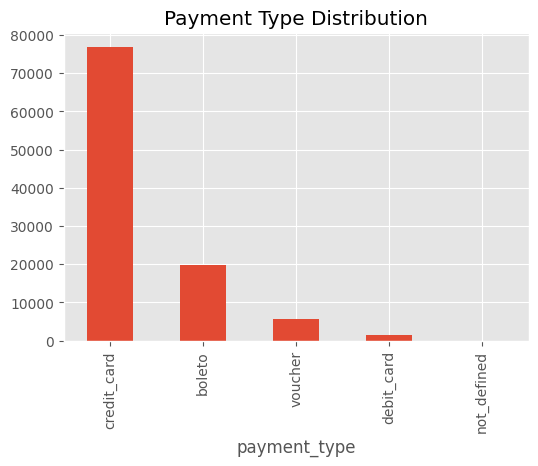

In [29]:
# Distribution

payments["payment_type"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("Payment Type Distribution")
plt.show()


In [31]:
# Outlier Detection

# IQR method for detecting high-value orders
Q1 = payments['payment_value'].quantile(0.25)
Q3 = payments['payment_value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

payments['high_value_order'] = payments['payment_value'] > upper_bound

print(f"Number of high-value orders: {payments['high_value_order'].sum()}")



Number of high-value orders: 7981


In [37]:
# Merge payments with order timestamps
payments_orders = payments.merge(
    orders[["order_id", "order_purchase_timestamp"]],
    on="order_id",
    how="left"
)


# Extract month
payments_orders['month'] = payments_orders['order_purchase_timestamp'].dt.to_period('M')

# Analyze high-value orders per month
high_value_monthly = (
    payments_orders[payments_orders["high_value_order"]]
    .groupby("month")
    .agg(
        high_value_order_count=("order_id", "count"),
        total_high_value_payment=("payment_value", "sum")
    )
    .reset_index()
)

print(high_value_monthly)


      month  high_value_order_count  total_high_value_payment
0   2016-10                      39                  24537.23
1   2017-01                      96                  59451.64
2   2017-02                     148                 108074.62
3   2017-03                     227                 171345.41
4   2017-04                     218                 164407.33
5   2017-05                     301                 206996.73
6   2017-06                     239                 176900.37
7   2017-07                     279                 166776.60
8   2017-08                     334                 223725.31
9   2017-09                     379                 273503.35
10  2017-10                     404                 287334.39
11  2017-11                     608                 399665.93
12  2017-12                     408                 260801.50
13  2018-01                     529                 339345.21
14  2018-02                     463                 284119.21
15  2018

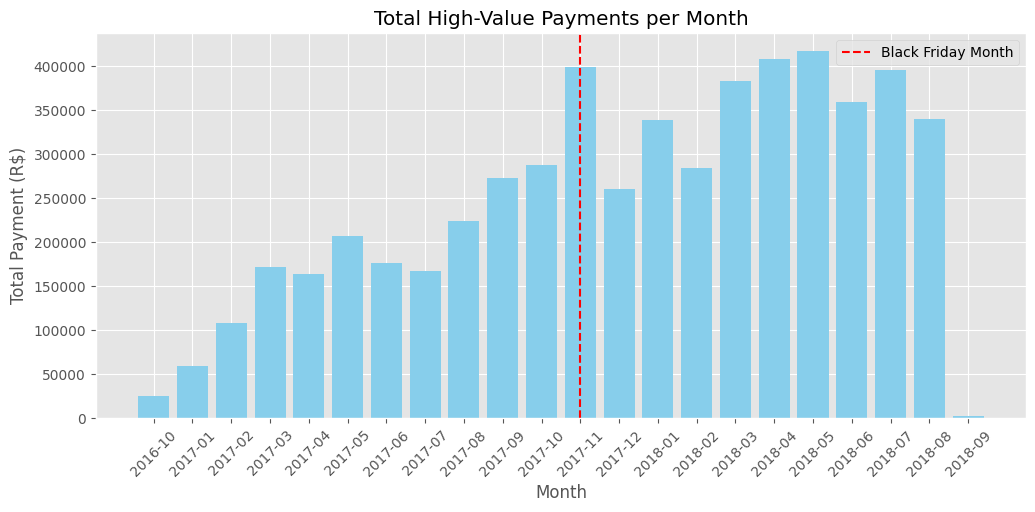

In [38]:
# Plot total high-value payments per month
plt.figure(figsize=(12,5))
plt.bar(high_value_month['month'].astype(str), high_value_month['total_payment'], color='skyblue')
plt.axvline(x='2017-11', color='red', linestyle='--', label='Black Friday Month')
plt.xticks(rotation=45)
plt.title('Total High-Value Payments per Month')
plt.xlabel('Month')
plt.ylabel('Total Payment (R$)')
plt.legend()
plt.show()


In [49]:
# 8. Export Data for PostgreSQL

import csv

def export_pg_csv(df, filename):
    """
    Export DataFrame to PostgreSQL-ready CSV.
    """
    df.to_csv(
        filename,
        index=False,
        sep=",",
        na_rep="\\N",
        quoting=csv.QUOTE_MINIMAL,
        date_format="%Y-%m-%d %H:%M:%S"
    )

# Loop over all tables
for filename, cols in tables_pg_info.items():
    # Remove '_pg.csv' to get the base name (e.g., 'orders', 'products')
    base_table_name = filename.replace('_pg.csv', '')

    # Construct the actual key used in the 'tables' dictionary
    # This assumes a consistent naming convention like 'olist_<base_name>_dataset'
    # There is an edge case for product_category_name_translation, but it's not in tables_pg_info currently.
    actual_table_key = f"olist_{base_table_name}_dataset"

    # Get the DataFrame
    df = tables[actual_table_key][cols]

    # Export
    export_pg_csv(df, filename)
    print(f"✅ {filename} exported")

✅ orders_pg.csv exported
✅ order_items_pg.csv exported
✅ order_payments_pg.csv exported
✅ products_pg.csv exported
✅ customers_pg.csv exported
✅ sellers_pg.csv exported
✅ geolocation_pg.csv exported
✅ order_reviews_pg.csv exported


In [50]:
import os

print("Current working directory:", os.getcwd())
print("Files here:", os.listdir())


Current working directory: /content
Files here: ['.config', 'products_pg.csv', 'customers_pg.csv', 'geolocation_pg.csv', 'order_items_pg.csv', 'orders_pg.csv', 'order_reviews_pg.csv', 'sellers_pg.csv', 'order_payments_pg.csv', 'sample_data']
